In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
import string

In [3]:
cd ..

/data/nasif12/home_if12/chengju/project/news


In [61]:
fkn = pd.read_pickle("./data/fkn.gzip")

In [62]:
fkn.head()

,index,title,text,label
0,8476,"[you, can, smell, hillari, fear]","[daniel, greenfield, shillman, journal, fellow...",1
1,10294,"[watch, the, exact, moment, paul, ryan, commit...","[googl, pinterest, digg, linkedin, reddit, stu...",1
2,3608,"[kerri, go, pari, gestur, sympathi]","[us, secretari, state, john, f, kerri, said, m...",0
3,10142,"[berni, support, twitter, erupt, anger, dnc, w...","[—, kayde, king, kaydeek, novemb, 9, 2016, the...",1
4,875,"[the, battl, new, york, whi, this, primari, ma...","[it, primari, day, new, york, frontrunn, hilla...",0


## Clean text data

## Pickle the output

In [111]:
#fkn.to_pickle("./data/fkn.gzip")

## Train validation test split

In [102]:
import numpy as np
import pandas as pd

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [103]:
train_dt, validate_dt, test_dt = train_validate_test_split(fkn)

In [104]:
print("training shape", train_dt.shape)
print("validating shape", validate_dt.shape)
print("testing shape", test_dt.shape)

training shape (3801, 4)
validating shape (1267, 4)
testing shape (1267, 4)


## tf-idf of text body

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [106]:
" ".join(fkn["title"][0])

'you can smell hillari fear'

In [107]:
train_dt["text"] = train_dt["text"].apply(lambda x: " ".join(x))

In [108]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_dt.text)
X_train_counts.shape

(3801, 49271)

In [109]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
y_train = train_dt["label"].as_matrix()

In [110]:
validate_dt["text"] = validate_dt["text"].apply(lambda x: " ".join(x))

In [111]:
X_val_counts = count_vect.transform(validate_dt.text)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
y_val = validate_dt["label"].as_matrix()

In [112]:
test_dt["text"] = test_dt["text"].apply(lambda x: " ".join(x))

In [113]:
X_test_counts = count_vect.transform(test_dt.text)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_test = test_dt["label"].as_matrix()

In [114]:
X_train_tfidf.shape

(3801, 49271)

(array([  2.82200000e+03,   7.89000000e+02,   1.10000000e+02,
          4.80000000e+01,   1.70000000e+01,   6.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([    0. ,   601.6,  1203.2,  1804.8,  2406.4,  3008. ,  3609.6,
         4211.2,  4812.8,  5414.4,  6016. ]),
 <a list of 10 Patch objects>)

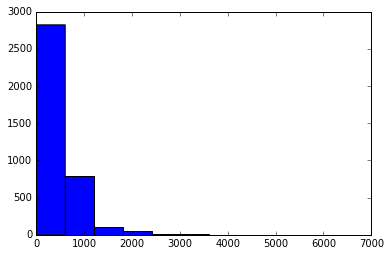

In [115]:
# Document lenght
plt.hist(X_train_counts.sum(1))

In [116]:
from src.helper import save_sparse_csr

In [117]:
save_sparse_csr("./data/X_train_tfidf", X_train_tfidf)
save_sparse_csr("./data/X_val_tfidf", X_val_tfidf)
save_sparse_csr("./data/X_test_tfidf", X_test_tfidf)

In [118]:
np.save("./data/y_train", y_train)
np.save("./data/y_val", y_val)
np.save("./data/y_test", y_test)

In [144]:
# X_train_tfidf = load_sparse_csr("./data/X_train_tfidf.npz")
# X_val_tfidf = load_sparse_csr("./data/X_val_tfidf.npz")
# X_test_tfidf = load_sparse_csr("./data/X_test_tfidf.npz")

In [48]:
X_train_counts.sum(0)[X_train_counts.sum(0) == 3]

matrix([[3, 3, 3, ..., 3, 3, 3]], dtype=int64)

## world could 

In [90]:
fkn1 = fkn[fkn["label"] == 1]
texts = fkn1["text"]
texts = texts.apply(lambda x: " ".join(x))

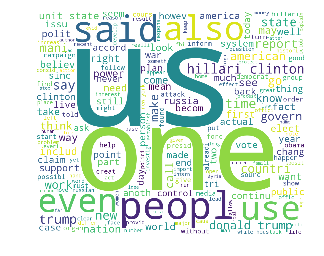

In [91]:
from wordcloud import WordCloud, STOPWORDS

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(" ".join(texts))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

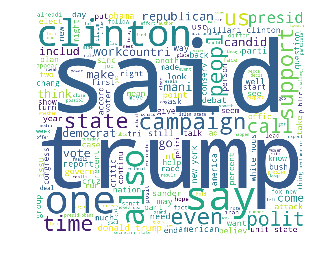

In [93]:
fkn1 = fkn[fkn["label"] == 0]
texts = fkn1["text"]
texts = texts.apply(lambda x: " ".join(x))
wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(" ".join(texts))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

In [98]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

In [99]:
clf = BernoulliNB()
clf.fit(X_train_tfidf, y_train)
predict_train = clf.predict(X_train_tfidf)
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, predict_train)
print(metrics.classification_report(y_train, predict_train))

             precision    recall  f1-score   support

          0       0.92      0.77      0.84      1897
          1       0.80      0.93      0.86      1904

avg / total       0.86      0.85      0.85      3801

